In [7]:
import pandas as pd
import sklearn
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt


In [8]:
df = pd.read_excel('DSGP dataSet2.xlsx')

In [9]:
df.head(10)

,VoiceClip_No,TextTranscripts,label
0,Voice1,"We want to increase our Wi-Fi services, increa...",Non
1,Voice2,I want to know whether I will be charged for t...,Non
2,Voice3,I made a complaint today morning.I did not ge...,Agg
3,Voice4,I'm calling to reactivate my line. I've been ...,Agg
4,Voice5,Can you check and tell me my balance ? \n,Non
5,Voice6,I want to log a complaint that my internet POT...,Non
6,Voice7,I would like to add on some GB to my connectio...,Non
7,Voice8,I have the LOS light Blinking red color in the...,Non
8,Voice9,\nActually I made this complaint on Saturday.O...,Agg
9,voice10,Hi can i know how much is the minimum that i s...,Non


In [10]:
df.columns

Index(['VoiceClip_No', 'TextTranscripts', 'label'], dtype='object')

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import re

def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = ' '.join([word for word in text.split() if not word.startswith('@')])  # Remove mentions (words starting with '@')
    text = re.sub(r'$\S+', '', text)  # Remove currency symbols
    text = re.sub(r'\d{10}', '', text)  # Remove contact numbers
    text = re.sub(r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}', '', text)  # Remove dates
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    tokens = text.split()
    tokens = [word for word in tokens if len(word) > 2]  # Remove short words (length <= 2)
    tokens = [word.lower() for word in tokens if word.isalnum()]  # Tokenization, lowercase, and removing stopwords
    # tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [13]:
df['processed_content'] = df['TextTranscripts'].apply(preprocess_text)

In [14]:
df.head(5)

,VoiceClip_No,TextTranscripts,label,processed_content
0,Voice1,"We want to increase our Wi-Fi services, increa...",Non,want increase our increase thespeed for the up...
1,Voice2,I want to know whether I will be charged for t...,Non,want know whether will charged for the for dia...
2,Voice3,I made a complaint today morning.I did not ge...,Agg,made complaint today did not get any calls fro...
3,Voice4,I'm calling to reactivate my line. I've been ...,Agg,calling reactivate been requesting this for th...
4,Voice5,Can you check and tell me my balance ? \n,Non,can you check and tell balance


In [15]:
print(df['label'].value_counts())

label
Agg    155
Non    114
Name: count, dtype: int64


In [16]:
df.to_csv('processed_datasetnew.csv')

In [17]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [18]:
x = df['TextTranscripts']
y = df['label']

In [19]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Classification Report for Random Forest on Testing Data:
              precision    recall  f1-score   support

         Agg       0.93      0.86      0.89        29
         Non       0.85      0.92      0.88        25

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.89      0.89      0.89        54



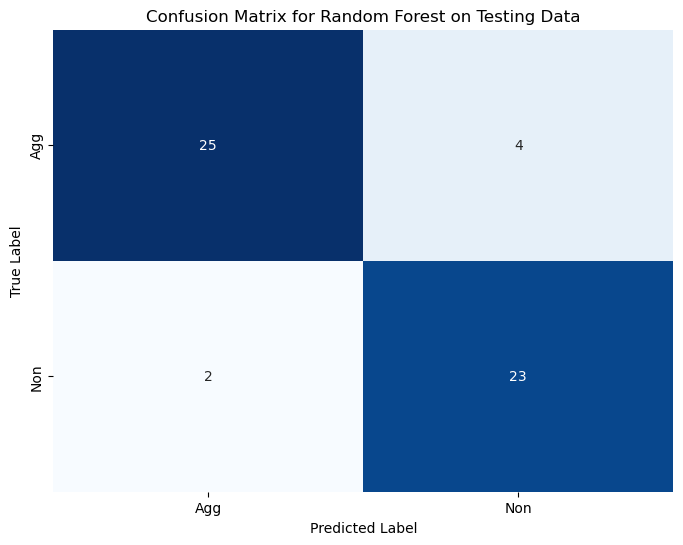

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming df is your DataFrame with 'Comments(x)' and 'Label(y)' columns

# Split the data into training and testing sets     20% - testing and 80% -traning
X_train, X_test, y_train, y_test = train_test_split(df['TextTranscripts'], df['label'], test_size=0.2, random_state=42)

# TF-IDF Vectorization (converts the text data(comments) into numerical features)
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter grid to search
#Grid search explores all possible combinations of these hyperparameters to find the optimal set
param_grid_rf = {
    'n_estimators': [100, 200, 300], # no of tress
    'max_depth': [None, 10, 20],  # maximum depth of trees
    'min_samples_split': [2, 5],  # minimum samples required to split a node
    'min_samples_leaf': [1, 2]    # minimum samples required at a leaf node
}

# Grid search with cross-validation on the training data to find the best hyperparameters for random forest
rf_classifier = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=3)
grid_search_rf.fit(X_train_tfidf, y_train)

# Best hyperparameters from the grid search
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf)

# Train the final Random Forest model with the best hyperparameters
final_rf_classifier = RandomForestClassifier(**best_params_rf, random_state=42)
final_rf_classifier.fit(X_train_tfidf, y_train)

# Predict class lab on the testing dataset
y_pred_rf = final_rf_classifier.predict(X_test_tfidf)

# Evaluate the final Random Forest model on the testing dataset
report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report for Random Forest on Testing Data:")
print(report_rf)




# Predict class labels on the testing dataset
y_pred_rf = final_rf_classifier.predict(X_test_tfidf)

# Compute the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=final_rf_classifier.classes_, 
            yticklabels=final_rf_classifier.classes_)
plt.title('Confusion Matrix for Random Forest on Testing Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



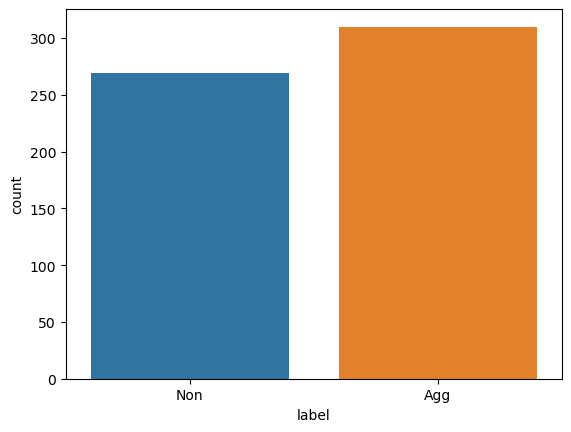

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.show()
